_Lambda School Data Science — Tree Ensembles_ 

# Decision Trees Assignment

## Part 1: House Price Regression

Apply decision trees to the Ames housing dataset you've worked with this week!

- Try multiple features
- Try features you've engineered
- Try different `max_depth` paramaters
- What's the best Test Root Mean Squared Error you can get? *Share with your cohort on Slack!*
- What's a cool visualization you can make? *Share with your cohort on Slack!*

In [0]:
%matplotlib inline
import graphviz
from IPython.display import display
from ipywidgets import interact
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz


def viztree(decision_tree, feature_names):
    """Visualize a decision tree"""
    dot_data = export_graphviz(decision_tree, out_file=None, feature_names=feature_names, 
                               filled=True, rounded=True)   
    return graphviz.Source(dot_data)


def viz3D(fitted_model, df, feature1, feature2, target='', num=100):
    """
    Visualize model predictions in 3D, for regression or binary classification
    
    Parameters
    ----------
    fitted_model : scikit-learn model, already fitted
    df : pandas dataframe, which was used to fit model
    feature1 : string, name of feature 1
    feature2 : string, name of feature 2
    target : string, name of target
    num : int, number of grid points for each feature
    
    References
    ----------
    https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
    https://scikit-learn.org/stable/auto_examples/tree/plot_iris.html  
    """
    x1 = np.linspace(df[feature1].min(), df[feature1].max(), num)
    x2 = np.linspace(df[feature2].min(), df[feature2].max(), num)
    X1, X2 = np.meshgrid(x1, x2)
    X = np.c_[X1.flatten(), X2.flatten()]
    if hasattr(fitted_model, 'predict_proba'):
        predicted = fitted_model.predict_proba(X)[:,1]
    else:
        predicted = fitted_model.predict(X)
    Z = predicted.reshape(num, num)
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(X1, X2, Z, cmap='viridis')
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_zlabel(target)
    return fig

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')

In [211]:
df.columns.tolist()

['Id',
 'MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF'

In [0]:
df['Bath'] = df['BsmtFullBath']+df['BsmtHalfBath']+df['FullBath']+df['HalfBath']
da = df
da = da.select_dtypes(include=['int'])
da = da.drop(columns='Id')

In [0]:
putts_X = df[['Bath']]
putts_y = df['SalePrice']


R^2 Score 0.37577465022232925


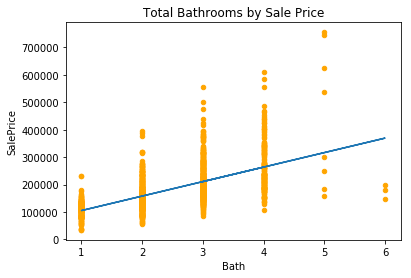

In [251]:
%matplotlib inline
import matplotlib.pyplot as plt


putts_y = df['SalePrice']
lr = LinearRegression()
lr.fit(putts_X, putts_y)
print('R^2 Score', lr.score(putts_X, putts_y))
ax = df.plot('Bath','SalePrice', kind='scatter', title='Total Bathrooms by Sale Price', color='orange')
ax.plot(putts_X, lr.predict(putts_X));

In [252]:
%matplotlib inline
import matplotlib.pyplot as plt


def viztree(decision_tree, feature_names):
    dot_data = export_graphviz(decision_tree, out_file=None, feature_names=feature_names, 
                               filled=True, rounded=True)   
    return graphviz.Source(dot_data)

def putts_tree(max_depth=1):
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(putts_X, putts_y)
    print('R^2 Score', tree.score(putts_X, putts_y))
    ax = df.plot('Bath', 'SalePrice', kind='scatter', title='Golf Putts', color='orange')
    ax.step(putts_X.sort_values(by='Bath'), tree.predict(putts_X.sort_values(by='Bath')), where='mid')
    plt.show()
    display(viztree(tree, feature_names=['SalePrice']))

interact(putts_tree, max_depth=(1,6,1));
#partial dependence plot mentioned in ml book
#mse mean squared error
#d tree viz hard to install 

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), Output()), _dom_classes=('wid…

In [0]:
df['space'] = df['TotRmsAbvGrd'] + df['TotalBsmtSF']
putts_X = df[['space']]

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), Output()), _dom_classes=('wid…

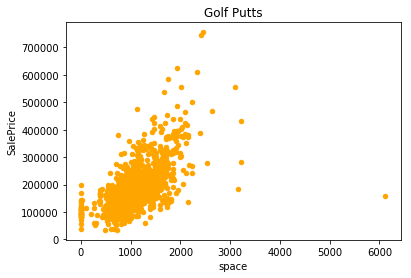

In [254]:
%matplotlib inline
import matplotlib.pyplot as plt


def viztree(decision_tree, feature_names):
    dot_data = export_graphviz(decision_tree, out_file=None, feature_names=feature_names, 
                               filled=True, rounded=True)   
    return graphviz.Source(dot_data)

def putts_tree(max_depth=1):
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(putts_X, putts_y)
    print('R^2 Score', tree.score(putts_X, putts_y))
    ax = df.plot('space', 'SalePrice', kind='scatter', title='Golf Putts', color='orange')
    ax.step(putts_X.sort_values(by='space'), tree.predict(putts_X.sort_values(by='space')), where='mid')
    plt.show()
    display(viztree(tree, feature_names=['SalePrice']))

interact(putts_tree, max_depth=(1,6,1));

In [0]:
ds = da['SalePrice']
da = da.drop(columns = 'SalePrice')


In [0]:
da = da.drop(columns = 'MiscVal')

In [0]:
da['total'] = da.sum(axis=1)
da['SalePrice'] = ds

In [0]:
X_train, X_test, y_train, y_test = train_test_split(da, ds, train_size=0.80, test_size=0.20, random_state=42)

In [333]:
X_train.shape, y_train.shape

((1168, 35), (1168,))

In [334]:
X_train.columns.tolist()

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MoSold',
 'YrSold',
 'Bath',
 'total',
 'SalePrice']

In [335]:
X_test.columns.tolist()

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MoSold',
 'YrSold',
 'Bath',
 'total',
 'SalePrice']

In [341]:
X_traintot = X_train[['total']]
target = 'SalePrice'

def viztree(decision_tree, feature_names):
    dot_data = export_graphviz(decision_tree, out_file=None, feature_names=feature_names, 
                               filled=True, rounded=True)   
    return graphviz.Source(dot_data)

def putts_tree(max_depth=1):
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(X_traintot, y_train)
    print('R^2 Score', tree.score(X_traintot, y_train))
    ax = X_test.plot('total', target, kind='scatter', title='All Integer Features by Sales Price', color='orange')
    ax.step(X_traintot.sort_values(by='total'), tree.predict(X_traintot.sort_values(by='total')), where='mid')
    plt.show()
    display(viztree(tree, feature_names=['SalePrice']))

interact(putts_tree, max_depth=(1,6,1));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), Output()), _dom_classes=('wid…

In [342]:
X_testot = X_test[['total']]
target = 'SalePrice'

def viztree(decision_tree, feature_names):
    dot_data = export_graphviz(decision_tree, out_file=None, feature_names=feature_names, 
                               filled=True, rounded=True)   
    return graphviz.Source(dot_data)

def putts_tree(max_depth=1):
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(X_testot, y_test)
    print('R^2 Score', tree.score(X_testot, y_test))
    ax = X_test.plot('total', target, kind='scatter', title='All Integer Features by Sales Price', color='orange')
    ax.step(X_testot.sort_values(by='total'), tree.predict(X_testot.sort_values(by='total')), where='mid')
    plt.show()
    display(viztree(tree, feature_names=['SalePrice']))

interact(putts_tree, max_depth=(1,6,1));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), Output()), _dom_classes=('wid…

In [338]:
lr = LinearRegression()
lr.fit(putts_X, putts_y)
print('R^2 Score', lr.score(putts_X, putts_y))
ax = da.plot('total','SalePrice', kind='scatter', title='All Integer Features by Sales Price', color='orange')
ax.plot(putts_X, lr.predict(putts_X));

ValueError: ignored

## Part 2 / Stretch: "Play Tennis" Classification

We'll reproduce the "Play Tennis" example from Ross Quinlan's 1986 paper, [Induction of Decison Trees](https://link.springer.com/content/pdf/10.1007%2FBF00116251.pdf).

[According to Wikipedia](https://en.wikipedia.org/wiki/Ross_Quinlan), "John Ross Quinlan is a computer science researcher in data mining and decision theory. He has contributed extensively to the development of decision tree algorithms, including inventing the canonical C4.5 and ID3 algorithms."

#### "Table 1 shows a small training set"

In [0]:
import pandas as pd

columns = 'No. Outlook Temperature Humidity Windy PlayTennis'.split()

raw = """1 sunny hot high false N
2 sunny hot high true N
3 overcast hot high false P
4 rain mild high false P
5 rain cool normal false P
6 rain cool normal true N
7 overcast cool normal true P
8 sunny mild high false N
9 sunny cool normal false P
10 rain mild normal false P
11 sunny mild normal true P
12 overcast mild high true P
13 overcast hot normal false P
14 rain mild high true N"""

data = [row.split() for row in raw.split('\n')]
tennis = pd.DataFrame(data=data, columns=columns).set_index('No.')
tennis['PlayTennis'] = (tennis['PlayTennis'] == 'P').astype(int)

tennis

,Outlook,Temperature,Humidity,Windy,PlayTennis
No.,,,,,
1,sunny,hot,high,false,0
2,sunny,hot,high,true,0
3,overcast,hot,high,false,1
4,rain,mild,high,false,1
5,rain,cool,normal,false,1
6,rain,cool,normal,true,0
7,overcast,cool,normal,true,1
8,sunny,mild,high,false,0
9,sunny,cool,normal,false,1


#### "A decision tree that correctly classifies each object in the training set is given in Figure 2."

<img src="https://i.imgur.com/RD7d0u0.png" height="300">

In this dataset, the tennis player decided to play on 64% of the days, and decided not to on 36% of the days.

In [0]:
tennis['PlayTennis'].value_counts(normalize=True) * 100

1    64.285714
0    35.714286
Name: PlayTennis, dtype: float64

The tennis player played on 100% of the overcast days, 40% of the sunny days, and 60% of the  rainy days

In [0]:
tennis.groupby('Outlook')['PlayTennis'].mean() * 100

Outlook
overcast    100.0
rain         60.0
sunny        40.0
Name: PlayTennis, dtype: float64

On sunny days, the tennis player's decision depends on the humidity. (The Outlook and Humidity features interact.)

In [0]:
sunny = tennis[tennis['Outlook']=='sunny']
sunny.groupby('Humidity')['PlayTennis'].mean() * 100

Humidity
high        0
normal    100
Name: PlayTennis, dtype: int64

On rainy days, the tennis player's decision depends on the wind. (The Outlook and Windy features interact.)

In [0]:
rainy = tennis[tennis['Outlook']=='rain']
rainy.groupby('Windy')['PlayTennis'].mean() * 100

Windy
false    100
true       0
Name: PlayTennis, dtype: int64

#### Before modeling, we will ["encode" categorical variables, using pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html?highlight=get_dummies#computing-indicator-dummy-variables)

In [0]:
y = tennis['PlayTennis']
X = pd.get_dummies(tennis.drop(columns='PlayTennis'))
X

(14, 10) (14,)


,Outlook_overcast,Outlook_rain,Outlook_sunny,Temperature_cool,Temperature_hot,Temperature_mild,Humidity_high,Humidity_normal,Windy_false,Windy_true
No.,,,,,,,,,,
1,0,0,1,0,1,0,1,0,1,0
2,0,0,1,0,1,0,1,0,0,1
3,1,0,0,0,1,0,1,0,1,0
4,0,1,0,0,0,1,1,0,1,0
5,0,1,0,1,0,0,0,1,1,0
6,0,1,0,1,0,0,0,1,0,1
7,1,0,0,1,0,0,0,1,0,1
8,0,0,1,0,0,1,1,0,1,0
9,0,0,1,1,0,0,0,1,1,0


## Train a Decision Tree Classifier
Get a score of 100% (accuracy)

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

## Compare to Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

## Visualize the tree
https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html